# Exploratory Data Analysis
 
 Following scraping data, we clean and explore the relationships between variables

## Cleaning the data

In [126]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from dateutil import parser as ps
import datetime as dt
from workalendar.usa import UnitedStates
from workalendar.asia import SouthKorea, China, Japan
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

In [203]:
# Read in the file
df=pd.read_pickle('./FullVGChartzDatabase.zip',compression = 'zip')
num_rows_original = df.shape[0]

In [204]:
# Turn all N/A's into np.nan values so pandas can operate with them easily
df_obj = df.select_dtypes('object')
df[df.columns] = df_obj.apply(lambda x: x.str.strip())
df=df.replace('N/A',np.nan)

In [205]:
# Merge columns total sales and total shipped because they describe the same thing but one is \
# for games no longer in production
df['total_shipped'].fillna(df['total_sales'],inplace = True)
df.dropna(subset=['total_shipped'],inplace = True)
df.drop(columns = ['total_sales','last_update','position'],inplace = True)

In [206]:
# Function to remove the 'm' and convert sales data column into floats
def drop_m(df,column_name):
    if column_name not in df.columns:
        return 'Cannot find column in dataframe!'
    df[column_name].loc[df[column_name].notnull()] = df[column_name].loc[df[column_name].notnull()].str[:-1].astype(float)
    return True

drop_m(df,'total_shipped')
drop_m(df,'pal_sales')
drop_m(df,'na_sales')
drop_m(df,'japan_sales')
drop_m(df,'other_sales');

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Outliers: 
Drop Wii sports because it was packaged with the Wii console in some locations and there aren't pubic concrete numbers as to how many were sold vs bundled with consoles. 

In [214]:

df=df.sort_values(by = 'total_shipped',ascending = False).drop(index = 0)

,game,console,publisher,developer,vgchart_score,critic_score,user_score,total_shipped,na_sales,pal_sales,japan_sales,other_sales,release_date
1,Super Mario Bros.,NES,Nintendo,Nintendo EAD,NaN,10.0,8.2,40.24,NaN,NaN,NaN,NaN,18th Oct 85
2,Mario Kart Wii,Wii,Nintendo,Nintendo EAD,8.7,8.2,9.1,37.14,NaN,NaN,NaN,NaN,27th Apr 08
3,PlayerUnknown's Battlegrounds,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,NaN,36.60,NaN,NaN,NaN,NaN,21st Dec 17
4,Wii Sports Resort,Wii,Nintendo,Nintendo EAD,8.8,8.0,8.8,33.09,NaN,NaN,NaN,NaN,26th Jul 09
5,Pokémon Red / Green / Blue Version,GB,Nintendo,Game Freak,NaN,9.4,NaN,31.38,NaN,NaN,NaN,NaN,30th Sep 98
6,New Super Mario Bros.,DS,Nintendo,Nintendo EAD,NaN,9.1,8.1,30.80,NaN,NaN,NaN,NaN,15th May 06
7,Tetris,GB,Nintendo,Bullet Proof Software,NaN,NaN,NaN,30.26,NaN,NaN,NaN,NaN,01st Jun 89
8,New Super Mario Bros. Wii,Wii,Nintendo,Nintendo EAD,9.1,8.6,9.2,30.22,NaN,NaN,NaN,NaN,15th Nov 09
9,Minecraft,PC,Mojang,Mojang AB,NaN,10.0,NaN,30.01,NaN,NaN,NaN,NaN,10th May 10
10,Duck Hunt,NES,Nintendo,Nintendo R&D1,NaN,NaN,NaN,28.31,NaN,NaN,NaN,NaN,15th Oct 85


In [87]:
# Convert date column to date time objects
datetime_column = df['release_date'].loc[df['release_date'].notnull()].apply(lambda item: ps.parse(str(item)))
df['release_date'] = datetime_column

In [88]:
df_sorted_by_date = df.sort_values(by = ['release_date']).reset_index()
#plt.scatter(df_sorted_by_date['release_date'].tolist(),np.log(df_sorted_by_date['total_shipped'].tolist())

In [89]:
 # df_sorted_by_date.loc[df_sorted_by_date['release_date'].astype(str)
df_sorted_by_date = df_sorted_by_date.loc[df_sorted_by_date['release_date'].astype(str) != 'NaT']

# How many points did cut out due to no release date?
df.shape[0] - df_sorted_by_date.shape[0]

522

In [90]:
# Drop bogus values with release date of 2020
df_sorted_by_date = df_sorted_by_date.loc[df_sorted_by_date['release_date'].apply(lambda element: element.year < 2020)]
df=df_sorted_by_date

# Filter for games with 100,000 sales or more
print("Number of games with < 100,000 shipped copies:",  df.loc[df['total_shipped'] < .09].shape[0])
df=df.loc[df['total_shipped'] > .09].sort_values(by = ['total_shipped'])

df['average_rating'] = df[['vgchart_score', 'critic_score','user_score']].astype(float).mean(axis=1)

# Filter out games with no ratings
print("Number of games with no ratings:",df.loc[df['average_rating'].isnull()].shape[0])
df = df.loc[df['average_rating'].notnull()]


Number of games with < 100,000 shipped copies 8042
Number of games with no ratings 8201


In [91]:
# After selecting games with 100,000+ sales and have ratings, how many rows left
df.sort_values(by = ['average_rating'],ascending = False).shape[0]

4001

In [92]:
df.drop(columns = ['vgchart_score','critic_score','user_score',\
                   'na_sales','pal_sales','japan_sales','other_sales',\
                   'developer'], inplace = True)

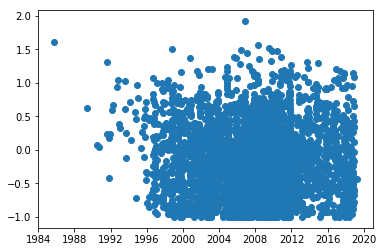

In [33]:

myplot = plt.scatter(df['release_date'],df['total_shipped'].apply(np.log10),)

In [34]:
df['release_year'] = df['release_date'].apply(lambda element: element.year)

In [35]:
df.head()

,index,game,console,publisher,total_shipped,release_date,average_rating,release_year
8299,12301,Dungeons & Dragons Tactics,PSP,Atari,0.1,2007-08-14,5.2,2007
3704,12320,Hunter: The Reckoning,GC,Interplay,0.1,2002-11-18,7.1,2002
2453,12430,Aidyn Chronicles: The First Mage,N64,THQ,0.1,2001-03-14,6.0,2001
12083,12220,JU-ON: The Grudge,Wii,Xseed Games,0.1,2009-10-13,4.0,2009
7811,12426,Bullet Witch,X360,Atari,0.1,2007-02-27,6.6,2007


# Things to be aware of:

- Some games were sold in packages (duck hunt, super mario)

- Some games were packaged with console ( wii sports)

- Calculate holidays based on US and East Asia (China, SK, Japan) will be about 75% of all consumers based off newZoo market research 2018

,index,game,console,publisher,total_shipped,release_date,average_rating,release_year


In [37]:
df_sorted_by_date.shape

(20689, 14)

In [94]:
# Set the range for days before holidays to look at
day_range = 4

def make_set_of_near_holidays(country,day_range):
    # Takes workalendar Country() object and makes a set of holidays between 1983 and 2018. Note:\
    # does not work on China, because China has insufficient data (holiday data only to 2018)
    set_of_near_holidays=set()
    # Number of days to include before holidays + 1 
    for year in range(1983,2019):
        for day_tuple in country.holidays(year):
            set_of_near_holidays.add(day_tuple[0]);
            for day_count in range(1,day_range):
                set_of_near_holidays.add(day_tuple[0] - dt.timedelta(days =day_count))
            #set_of_near_holidays.append(day_tuple[0]) - dt.timedelta(days = 1);
    # Save unique holidays
    return (set_of_near_holidays)


In [95]:
# These three countries capture ~75% of market according to Newzoo market data for 2018. Therefore we'll look
# at market data for just these.

us_holidays = make_set_of_near_holidays(UnitedStates(),day_range)
south_korea_holidays = make_set_of_near_holidays(SouthKorea(),day_range);
japan_holidays = make_set_of_near_holidays(Japan(),day_range)
# workalendar package only includes 2018 data for China, so it needs its own code. We'll approximate\
# the past years' holiday dates as close to 2018 dates.
china_holidays = set()
for date_tuple in China().holidays(2018):
    china_holidays.add(date_tuple[0])
    for day_count in range(1,day_range):
        china_holidays.add(date_tuple[0] - dt.timedelta(days = day_count))


/anaconda3/lib/python3.7/site-packages/workalendar/asia/china.py:63: UserWarning: Support 2018, 2019 currently, need update every year.
  warnings.warn("Support 2018, 2019 currently, need update every year.")


In [96]:
# Convert from pandas Timestamp to python datetime
df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())

In [97]:
df['near_us_holiday'] = df['release_date'].apply(lambda x: x in us_holidays)
df['near_sk_holiday'] = df['release_date'].apply(lambda x: x in south_korea_holidays)
df['near_jp_holiday'] = df['release_date'].apply(lambda x: x in japan_holidays)

In [98]:
# Compare all China holidays to 2018 because that's the only dataset available
def convert_day_to_2018(input_datetime):
    if(input_datetime.month == 2 and input_datetime.day == 29):
        day_corrected = input_datetime.day - 1
    else:
        day_corrected = input_datetime.day
        
    return dt.date(year = 2018, month = input_datetime.month, day = day_corrected)
df['near_cn_holiday'] = df['release_date'].apply(lambda x: convert_day_to_2018(x) in china_holidays)

In [99]:
df['years_since_release'] = dt.datetime.now().year - df['release_year']

KeyError: 'release_year'

In [100]:
df = df.drop(columns='index')


# Workflow - Project 2


## Compare features

- pair plots
- bar charts
- group by time

## Read online sources

- what do experts say will increase target variable

## Hypothesis what linear model may tell you

- what are expectations

## Fit basic model before feature manipulation

- see if statistics are stastically sig
- normally distributed residuals
- check null hypothesis, p value
- this is baseline model
- standardize features

## Try polynomial fitting , LR_2, LR_custom feature extraction

- Compare different iterations

## Regularization

- Polynomial to 3rd or 4th degree / transforms to try to normally distribute
- increase lambda slowly to see when results give low error
- that is ideal level of complexity

## Other things:

- Start **TOO COMPLEX** before grid search
- Need to be 'to the right' of optimal point

### Grid search
- for regularization
- use log scale for lambda .0001 to 100,000
- for alpha and complement > 0 to 1
- for each  alpha and lambda, cross validate 
- sk learn will give you best model parameters
    - choose best model based on stuff like meansquared error on out of smaple data
- after finding model, you are **done**

### Pipeline
- for this project, don't need to mess with it

In [102]:
df.iloc[:,:]

,game,console,publisher,total_shipped,release_date,average_rating,near_us_holiday,near_sk_holiday,near_jp_holiday,near_cn_holiday
8299,Dungeons & Dragons Tactics,PSP,Atari,0.10,2007-08-14,5.200000,False,True,False,False
3704,Hunter: The Reckoning,GC,Interplay,0.10,2002-11-18,7.100000,False,False,False,False
2453,Aidyn Chronicles: The First Mage,N64,THQ,0.10,2001-03-14,6.000000,False,False,False,False
12083,JU-ON: The Grudge,Wii,Xseed Games,0.10,2009-10-13,4.000000,False,False,False,False
7811,Bullet Witch,X360,Atari,0.10,2007-02-27,6.600000,False,True,False,False
7766,Ar tonelico: Melody of Elemia,PS2,Nippon Ichi Software,0.10,2007-02-06,7.000000,False,False,False,False
14080,MindJack,X360,Square Enix,0.10,2011-01-18,4.500000,False,False,False,False
7683,Disney's Chicken Little: Ace In Action,Wii,Buena Vista,0.10,2006-12-11,7.600000,False,False,False,False
18967,Shantae and the Pirate's Curse,3DS,WayForward Technologies,0.10,2016-10-18,7.700000,False,False,False,False
8070,Surf's Up,X360,Ubisoft,0.10,2007-05-30,6.200000,False,False,False,False


In [103]:
# Grabbed from 2018 top revenue publishers, mergers like activision blizzard are split to identify games released 
# independently.
def in_top_10_publishers(publisher_name):
    publisher_name = publisher_name.lower()
    top_publishers = ['sony','microsoft','nintendo',\
                  'activision','blizzard','bandai','namco','square','enix'\
                 'ubisoft','electronic arts','ea sports']
    for top_pub in top_publishers:
        if top_pub in publisher_name:
            return True
    return False
df['top_10_publisher'] = df['publisher'].apply(lambda x: in_top_10_publishers(x))

In [104]:
scaler = StandardScaler()
data = df[['total_shipped','average_rating']]
scaler.fit(data)
scaler.transform(data)

array([[-0.43682766, -1.63861643],
       [-0.43682766, -0.22681059],
       [-0.43682766, -1.04417186],
       ...,
       [12.12615861,  0.93731001],
       [13.17759645,  1.25930082],
       [27.63317082,  0.21902283]])

In [129]:
df.rename(columns={'total_shipped':'total_shipped_in_mil'}, inplace=True)


AttributeError: module 'datetime' has no attribute 'today'

In [164]:
df['years_since_release'] = (dt.datetime.now().toordinal()-\
                             df['release_date'].apply(lambda x: dt.date.toordinal(x)))/365

In [165]:
df['years_since_release']

8299     11.676712
3704     16.416438
2453     18.098630
12083     9.509589
7811     12.136986
7766     12.194521
14080     8.243836
7683     12.350685
18967     2.490411
8070     11.884932
7996     11.964384
16287     6.076712
2934     17.334247
12579     9.317808
12648     9.202740
10182    10.487671
9574     10.849315
3889     16.183562
10101    10.509589
12347     9.449315
13039     8.915068
13099     8.876712
3734     16.408219
13120     8.857534
12974     8.972603
12822     9.101370
9356     11.063014
12142     9.490411
14957     7.515068
1803     19.553425
           ...    
2596     17.778082
5425     14.419178
19358     1.964384
14222     8.115068
19075     2.405479
3571     16.473973
3945     16.090411
16614     5.509589
5319     14.476712
7992     11.972603
15368     7.367123
6857     13.002740
17520     4.408219
16561     5.578082
248      27.690411
12022     9.534247
9494     10.906849
2227     18.512329
6413     13.424658
5960     13.652055
13814     8.449315
7773     12.

In [166]:
df_features = df.drop(columns = 'release_date')

In [167]:
df_features

,game,console,publisher,total_shipped_in_mil,average_rating,near_us_holiday,near_sk_holiday,near_jp_holiday,near_cn_holiday,top_10_publisher,years_since_release
8299,Dungeons & Dragons Tactics,PSP,Atari,0.10,5.200000,False,True,False,False,False,11.676712
3704,Hunter: The Reckoning,GC,Interplay,0.10,7.100000,False,False,False,False,False,16.416438
2453,Aidyn Chronicles: The First Mage,N64,THQ,0.10,6.000000,False,False,False,False,False,18.098630
12083,JU-ON: The Grudge,Wii,Xseed Games,0.10,4.000000,False,False,False,False,False,9.509589
7811,Bullet Witch,X360,Atari,0.10,6.600000,False,True,False,False,False,12.136986
7766,Ar tonelico: Melody of Elemia,PS2,Nippon Ichi Software,0.10,7.000000,False,False,False,False,False,12.194521
14080,MindJack,X360,Square Enix,0.10,4.500000,False,False,False,False,True,8.243836
7683,Disney's Chicken Little: Ace In Action,Wii,Buena Vista,0.10,7.600000,False,False,False,False,False,12.350685
18967,Shantae and the Pirate's Curse,3DS,WayForward Technologies,0.10,7.700000,False,False,False,False,False,2.490411
8070,Surf's Up,X360,Ubisoft,0.10,6.200000,False,False,False,False,False,11.884932


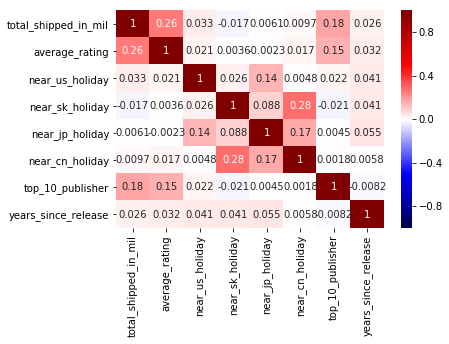

In [168]:

sns.heatmap(df_features.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [177]:

df_features.drop(columns = ['game','console','publisher'],inplace = True)

In [191]:
def patsy_string_from_df(df_features):
    patsy_string = "total_shipped_in_mil ~ "
    for title in df_features.columns[1:]:
        patsy_string += title + " + "
    #remove last plus and spaces from string
    patsy_string=patsy_string[:-3]
    return patsy_string


In [192]:
y, X = patsy.dmatrices(patsy_string_from_df(df_features), data=df_features, return_type="dataframe")

In [195]:
def sm_OLS_model(df_features):
    y, X = patsy.dmatrices(patsy_string_from_df(df_features), data=df_features, return_type="dataframe")
    model = sm.OLS(y, X)
    # Fit your model to your training set
    fit = model.fit()

    # Print summary statistics of the model's performance
    return fit.summary()

In [183]:
df_features.head()

,total_shipped_in_mil,average_rating,near_us_holiday,near_sk_holiday,near_jp_holiday,near_cn_holiday,top_10_publisher,years_since_release
8299,0.1,5.2,False,True,False,False,False,11.676712
3704,0.1,7.1,False,False,False,False,False,16.416438
2453,0.1,6.0,False,False,False,False,False,18.098630
12083,0.1,4.0,False,False,False,False,False,9.509589
7811,0.1,6.6,False,True,False,False,False,12.136986


In [194]:
# It looks like release date proximity to holidays doesn't really have an impact on total sales. Let's drop those
df_features.drop(columns = ['near_sk_holiday','near_jp_holiday','near_cn_holiday'],inplace = True)
patsy_string_from_df(df_features)


'total_shipped_in_mil ~ average_rating + near_us_holiday + top_10_publisher + years_since_release'

In [196]:
sm_OLS_model(df_features)

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     total_shipped_in_mil   R-squared:                       0.087
Model:                              OLS   Adj. R-squared:                  0.086
Method:                   Least Squares   F-statistic:                     95.52
Date:                  Mon, 15 Apr 2019   Prob (F-statistic):           1.01e-77
Time:                          15:42:47   Log-Likelihood:                -9820.5
No. Observations:                  4001   AIC:                         1.965e+04
Df Residuals:                      3996   BIC:                         1.968e+04
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.9670      0.266    -11.161      0.000      -3.488      -2.446
near_us_holiday[T.True]      0.2599      0.165      1.578      0.115      -0.063       0.583
top_10_publisher[T.True]     0.8331      0.091      9.190      0.000       0.655       1.011
average_rating               0.5186      0.034     15.477      0.000       0.453       0.584
years_since_release          0.0108      0.009      1.203      0.229      -0.007       0.028
==============================================================================
Omnibus:                     6472.114   Durbin-Watson:                   0.211
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7116319.608
Skew:                          10.294   Prob(JB):                         0.00
Kurtosis:                     208.581   Cond. No.                         84.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

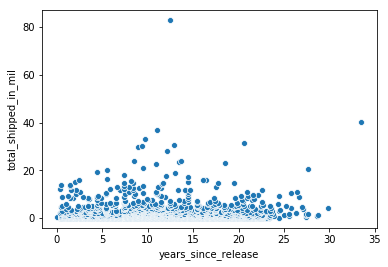

In [198]:
sns.scatterplot('years_since_release','total_shipped_in_mil',data = df_features)